### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot JES/JER up/down distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector


/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [3]:
#load the slimmedtree files using uproot

#different year available here.
# year = "2016"
# year = "2017"
year = "2018"
# year = "Full-Run2"

#if run on CMSconnect, use this:

# CustNanoData = {
#     'TotalSignal' : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/Signal/SlimmedTree_Total.root"%(year),
#     'ggF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/Signal/SlimmedTree_GluGlu.root"%(year),
#     'VH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/Signal/SlimmedTree_VH.root"%(year),
#     'ttH'         : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/Signal/SlimmedTree_ttH.root"%(year),
#     'VBF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/Signal/SlimmedTree_VBF.root"%(year),
# } 

CustNanoData = {
    'TotalSignal'   : "/data/bond/zhaoyz/SlimmedTree/V7/%s/Signal/SlimmedTree_Total.root"%(year),
    # 'WJets'       : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/MC/SlimmedTree_WJets.root"%(year),
    # 'Top'         : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/MC/SlimmedTree_Top.root"%(year),
    # 'Rest'        : "/ospool/cms-user/yuzhe/SlimmedTree/V6/%s/MC/SlimmedTree_Rest.root"%(year),
} 

files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })


### Get DPhi in the events

In [4]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_corr_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: TotalSignal
[2.66, 1.61, 1.12, 0.109, 1.49, 1.81, 2.33, ... 1.29, 2.82, 2.8, 2.35, 0.21, 0.229]


### Get MET recovery mass(consider the JES/JER up/down content)

In [5]:

def get_reco(events,mass = "Mj_corr_V2_a", MET_UE = None):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events[mass]
    if not MET_UE:
        pT_MET = events["MET_et"]
        phi_MET = events["MET_phi"]
    elif MET_UE == "up":
        pT_MET = events["MET_et_UEup"]
        phi_MET = events["MET_phi_UEup"]
    elif MET_UE == "down":
        pT_MET = events["MET_et_UEdown"]
        phi_MET = events["MET_phi_UEdown"]
    eta_MET = events["Etaj_V2_a"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    if not MET_UE: mass_str = "MH_Reco" if mass == "Mj_corr_V2_a" else mass
    else : mass_str = "MH_Reco" + "_UE_" + MET_UE
    
    if not MET_UE: 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])
    elif MET_UE == "up" : 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et_UEup"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])
    elif MET_UE == "down" : 
        events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et_UEdown"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])
    
for k in files:
    print("Add reco of:",k)
    get_reco(events=files[k])
    get_reco(events=files[k],MET_UE = "up")
    get_reco(events=files[k],MET_UE = "down")
    
    get_reco(events=files[k],mass = "Mj_jesTotalUp_a")
    get_reco(events=files[k],mass = "Mj_jesTotalDown_a")
    get_reco(events=files[k],mass = "Mj_jerUp_a")
    get_reco(events=files[k],mass = "Mj_jerDown_a")
    
    get_reco(events=files[k],mass = "Mj_jmsUp_a")
    get_reco(events=files[k],mass = "Mj_jmsDown_a")
    get_reco(events=files[k],mass = "Mj_jmrUp_a")
    get_reco(events=files[k],mass = "Mj_jmrDown_a")
    
    #split JES
    get_reco(events=files[k],mass = "Mj_jesAbsoluteUp_a")
    get_reco(events=files[k],mass = "Mj_jesAbsoluteDown_a")
    get_reco(events=files[k],mass = "Mj_jesAbsolute_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesAbsolute_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1Down_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1Up_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesBBEC1_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesEC2Up_a")
    get_reco(events=files[k],mass = "Mj_jesEC2Down_a")
    get_reco(events=files[k],mass = "Mj_jesEC2_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesEC2_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesFlavorQCDUp_a")
    get_reco(events=files[k],mass = "Mj_jesFlavorQCDDown_a")
    get_reco(events=files[k],mass = "Mj_jesHFDown_a")
    get_reco(events=files[k],mass = "Mj_jesHFUp_a")
    get_reco(events=files[k],mass = "Mj_jesHF_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesHF_yearDown_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeBalUp_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeBalDown_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeSample_yearUp_a")
    get_reco(events=files[k],mass = "Mj_jesRelativeSample_yearDown_a")
    

Add reco of: TotalSignal


### output all the variables for which we can make plots

In [ ]:
files["TotalSignal"].fields

### plot setting, error setting, histogram setting

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


In [7]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/plots/variation/16Apr24"
_ = os.system(f"mkdir -p {plot_dir}")

### define main plots function

In [ ]:
def plot_JES_JER_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_JES = True,year = "2018",files_str = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    files = files[files_str]
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_JES:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jesTotalUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JES,total up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jesTotalDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JES,total down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JES,total up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JES,total down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JES_{year}_{region}{files_str}.pdf", bbox_inches='tight')    
    else: 
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jerUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JER,up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jerDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JER,down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JER,up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JER,down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JER_{year}_{region}{files_str}.pdf", bbox_inches='tight')    

In [ ]:
plot_JES_JER_variation(files, files_str = "TotalSignal",region = "SR1a")
plot_JES_JER_variation(files, files_str = "TotalSignal",region = "SR1b")
plot_JES_JER_variation(files, files_str = "TotalSignal",region = "SR2a")
plot_JES_JER_variation(files, files_str = "TotalSignal",region = "SR2b")
plot_JES_JER_variation(files, files_str = "TotalSignal",region = "PS")

plot_JES_JER_variation(files, files_str = "TotalSignal",plot_JES = False, region = "SR1a")
plot_JES_JER_variation(files, files_str = "TotalSignal",plot_JES = False, region = "SR1b")
plot_JES_JER_variation(files, files_str = "TotalSignal",plot_JES = False, region = "SR2a")
plot_JES_JER_variation(files, files_str = "TotalSignal",plot_JES = False, region = "SR2b")
plot_JES_JER_variation(files, files_str = "TotalSignal",plot_JES = False, region = "PS")

plot_JES_JER_variation(files, files_str = "WJets" ,region = "SR1a")
plot_JES_JER_variation(files, files_str = "WJets" ,region = "SR1b")
plot_JES_JER_variation(files, files_str = "WJets" ,region = "SR2a")
plot_JES_JER_variation(files, files_str = "WJets" ,region = "SR2b")
plot_JES_JER_variation(files, files_str = "WJets" ,region = "PS")

plot_JES_JER_variation(files, files_str = "WJets",plot_JES = False, region = "SR1a")
plot_JES_JER_variation(files, files_str = "WJets",plot_JES = False, region = "SR1b")
plot_JES_JER_variation(files, files_str = "WJets",plot_JES = False, region = "SR2a")
plot_JES_JER_variation(files, files_str = "WJets",plot_JES = False, region = "SR2b")
plot_JES_JER_variation(files, files_str = "WJets",plot_JES = False, region = "PS")

plot_JES_JER_variation(files, files_str = "Top" , region = "SR1a")
plot_JES_JER_variation(files, files_str = "Top" , region = "SR1b")
plot_JES_JER_variation(files, files_str = "Top" , region = "SR2a")
plot_JES_JER_variation(files, files_str = "Top" , region = "SR2b")
plot_JES_JER_variation(files, files_str = "Top" , region = "PS")

plot_JES_JER_variation(files, files_str = "Top",plot_JES = False, region = "SR1a")
plot_JES_JER_variation(files, files_str = "Top",plot_JES = False, region = "SR1b")
plot_JES_JER_variation(files, files_str = "Top",plot_JES = False, region = "SR2a")
plot_JES_JER_variation(files, files_str = "Top",plot_JES = False, region = "SR2b")
plot_JES_JER_variation(files, files_str = "Top",plot_JES = False, region = "PS")

### analyze pu weight up/down variation

In [ ]:
def plot_pu_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018",files_str = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    files = files[files_str]
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightUp"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="pileup(PU), up variation", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightDown"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="pileup(PU), down variation", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="down var./center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + "," + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/PU_{year}_{region}{files_str}.pdf", bbox_inches='tight')    



In [ ]:

plot_pu_variation(files, files_str = "TotalSignal", region = "SR1a")
plot_pu_variation(files, files_str = "TotalSignal", region = "SR1b")
plot_pu_variation(files, files_str = "TotalSignal", region = "SR2a")
plot_pu_variation(files, files_str = "TotalSignal", region = "SR2b")
plot_pu_variation(files, files_str = "TotalSignal", region = "PS")

plot_pu_variation(files, files_str = "WJets",region = "SR1a")
plot_pu_variation(files, files_str = "WJets",region = "SR1b")
plot_pu_variation(files, files_str = "WJets",region = "SR2a")
plot_pu_variation(files, files_str = "WJets",region = "SR2b")
plot_pu_variation(files, files_str = "WJets",region = "PS")

plot_pu_variation(files, files_str = "Top",region = "SR1a")
plot_pu_variation(files, files_str = "Top",region = "SR1b")
plot_pu_variation(files, files_str = "Top",region = "SR2a")
plot_pu_variation(files, files_str = "Top",region = "SR2b")
plot_pu_variation(files, files_str = "Top",region = "PS")

### analyze LHE Scale weight variation

### Test some weight(LHE Scale Weight, PS Weight)

In [ ]:
files["TotalSignal"].LHEScaleWeight_4


In [ ]:
files["TotalSignal"].PSWeight_2


### Test MET UE(unclusted energy) up/down variation

In [ ]:
files["TotalSignal"].MET_et_UEup


In [ ]:
files["TotalSignal"].MET_et

In [ ]:
files["TotalSignal"].MET_et_UEdown


### Plot LHE Scale variation

In [ ]:
def plot_LHEScale_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018",files_str = ''):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    files = files[files_str]
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        
        # center value
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_center = flow(hist_region)[0]
        hist_var_center   = flow(hist_region)[1]
        err_center = np.nan_to_num(error_bar(hist_value_center, hist_var_center, type = "mc"), nan = 0)
        hep.histplot(hist_value_center, bins=hist_region.axes[0].edges, yerr=err_center, label="center value", histtype='step', stack=False, linewidth=2, ax=ax, color = "black")

        # 0th weight:0.5,0.5
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_0"][maskdict_sr(files,region)])
        hist_value_0 = flow(hist_region)[0]
        hist_var_0   = flow(hist_region)[1]
        err_0 = np.nan_to_num(error_bar(hist_value_0, hist_var_0, type = "mc"), nan = 0)
        hep.histplot(hist_value_0, bins=hist_region.axes[0].edges, yerr=err_0, label=r"$\mu_{R}=0.5,\mu_{F}=0.5$", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

        # 1st weight:0.5,1
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_1"][maskdict_sr(files,region)])
        hist_value_1 = flow(hist_region)[0]
        hist_var_1   = flow(hist_region)[1]
        err_1 = np.nan_to_num(error_bar(hist_value_1, hist_var_1, type = "mc"), nan = 0)
        hep.histplot(hist_value_1, bins=hist_region.axes[0].edges, yerr=err_1, label=r"$\mu_{R}=0.5,\mu_{F}=1$", histtype='step', stack=False, linewidth=2, ax=ax,color = "#ff5733")

        # 3rd weight:1,0.5
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_3"][maskdict_sr(files,region)])
        hist_value_3 = flow(hist_region)[0]
        hist_var_3   = flow(hist_region)[1]
        err_3 = np.nan_to_num(error_bar(hist_value_3, hist_var_3, type = "mc"), nan = 0)
        hep.histplot(hist_value_3, bins=hist_region.axes[0].edges, yerr=err_3, label=r"$\mu_{R}=1,\mu_{F}=0.5$", histtype='step', stack=False, linewidth=2, ax=ax,color = "#33cc33")

        # 4th weight:1,1
        # hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        # hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_4"][maskdict_sr(files,region)])
        # hist_value_4 = flow(hist_region)[0]
        # hist_var_4   = flow(hist_region)[1]
        # err_4 = np.nan_to_num(error_bar(hist_value_4, hist_var_4, type = "mc"), nan = 0)
        # hep.histplot(hist_value_4, bins=hist_region.axes[0].edges, yerr=err_4, label=r"$\mu_{R}=1,\mu_{F}=1$", histtype='step', stack=False, linewidth=2, ax=ax,color = "magenta")

        # 5th weight:1,2
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_5"][maskdict_sr(files,region)])
        hist_value_5 = flow(hist_region)[0]
        hist_var_5   = flow(hist_region)[1]
        err_5 = np.nan_to_num(error_bar(hist_value_5, hist_var_5, type = "mc"), nan = 0)
        hep.histplot(hist_value_5, bins=hist_region.axes[0].edges, yerr=err_5, label=r"$\mu_{R}=1,\mu_{F}=2$", histtype='step', stack=False, linewidth=2, ax=ax,color = "#7fffd4")

        # 7th weight:2,1
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_7"][maskdict_sr(files,region)])
        hist_value_7 = flow(hist_region)[0]
        hist_var_7   = flow(hist_region)[1]
        err_7 = np.nan_to_num(error_bar(hist_value_7, hist_var_7, type = "mc"), nan = 0)
        hep.histplot(hist_value_7, bins=hist_region.axes[0].edges, yerr=err_7, label=r"$\mu_{R}=2,\mu_{F}=1$", histtype='step', stack=False, linewidth=2, ax=ax,color = "yellow")

        # 8th weight:2,2
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight_8"][maskdict_sr(files,region)])
        hist_value_8 = flow(hist_region)[0]
        hist_var_8   = flow(hist_region)[1]
        err_8 = np.nan_to_num(error_bar(hist_value_8, hist_var_8, type = "mc"), nan = 0)
        hep.histplot(hist_value_8, bins=hist_region.axes[0].edges, yerr=err_8, label=r"$\mu_{R}=2,\mu_{F}=2$", histtype='step', stack=False, linewidth=2, ax=ax,color = "#8a2be2")
        
        #error of ratio:
        err_0   = np.sqrt(np.power(err_0/hist_value_0,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_0/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_0,   label=r"$\mu_{R}=0.5,\mu_{F}=0.5$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "blue")
    
        err_1   = np.sqrt(np.power(err_1/hist_value_1,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_1/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_1,   label=r"$\mu_{R}=0.5,\mu_{F}=1$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "#ff5733")

        err_3   = np.sqrt(np.power(err_3/hist_value_3,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_3/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_3 ,  label=r"$\mu_{R}=1,\mu_{F}=0.5$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "#33cc33")

        # err_4   = np.sqrt(np.power(err_4/hist_value_4,2) + np.power(err_center/hist_value_center,2))
        # hep.histplot(hist_value_4/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_0,   label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "magenta")

        err_5   = np.sqrt(np.power(err_5/hist_value_5,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_5/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_5,   label=r"$\mu_{R}=1,\mu_{F}=2$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "#7fffd4")

        err_7   = np.sqrt(np.power(err_7/hist_value_7,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_7/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_7,   label=r"$\mu_{R}=2,\mu_{F}=1$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "yellow")

        err_8   = np.sqrt(np.power(err_8/hist_value_8,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_8/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_8,   label=r"$\mu_{R}=2,\mu_{F}=2$ var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "#8a2be2")
        
        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=3, frameon=False, fontsize=16)
        plt.text(0.05,0.83,region + ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/LHEScale_{year}_{region}{files_str}.pdf", bbox_inches='tight')    



In [ ]:
plot_LHEScale_variation(files , files_str = "TotalSignal",region = "SR1a")
plot_LHEScale_variation(files , files_str = "TotalSignal",region = "SR1b")
plot_LHEScale_variation(files , files_str = "TotalSignal",region = "SR2a")
plot_LHEScale_variation(files , files_str = "TotalSignal",region = "SR2b")
plot_LHEScale_variation(files , files_str = "TotalSignal",region = "PS")

plot_LHEScale_variation(files, files_str = "WJets",region = "SR1a")
plot_LHEScale_variation(files, files_str = "WJets",region = "SR1b")
plot_LHEScale_variation(files, files_str = "WJets",region = "SR2a")
plot_LHEScale_variation(files, files_str = "WJets",region = "SR2b")
plot_LHEScale_variation(files, files_str = "WJets",region = "PS")

plot_LHEScale_variation(files, files_str = "Top" , region = "SR1a")
plot_LHEScale_variation(files, files_str = "Top" , region = "SR1b")
plot_LHEScale_variation(files, files_str = "Top" , region = "SR2a")
plot_LHEScale_variation(files, files_str = "Top" , region = "SR2b")
plot_LHEScale_variation(files, files_str = "Top" , region = "PS")

### Plot PS weight variation

In [ ]:
def plot_PS_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018",files_str = ''):
    files = files[files_str]
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        # center value
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_center = flow(hist_region)[0]
        hist_var_center   = flow(hist_region)[1]
        err_center = np.nan_to_num(error_bar(hist_value_center, hist_var_center, type = "mc"), nan = 0)
        hep.histplot(hist_value_center, bins=hist_region.axes[0].edges, yerr=err_center, label="center value", histtype='step', stack=False, linewidth=2, ax=ax, color = "black")

        # ISR up
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["PSWeight_0"][maskdict_sr(files,region)])
        hist_value_0 = flow(hist_region)[0]
        hist_var_0   = flow(hist_region)[1]
        err_0 = np.nan_to_num(error_bar(hist_value_0, hist_var_0, type = "mc"), nan = 0)
        hep.histplot(hist_value_0, bins=hist_region.axes[0].edges, yerr=err_0, label="ISR=2,FSR=1(ISR up variation)", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

        # ISR down
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["PSWeight_2"][maskdict_sr(files,region)])
        hist_value_1 = flow(hist_region)[0]
        hist_var_1   = flow(hist_region)[1]
        err_1 = np.nan_to_num(error_bar(hist_value_1, hist_var_1, type = "mc"), nan = 0)
        hep.histplot(hist_value_1, bins=hist_region.axes[0].edges, yerr=err_1, label="ISR=0.5,FSR=1(ISR down variation)", histtype='step', stack=False, linewidth=2, ax=ax,color = "red")

        #error of ratio:
        err_0   = np.sqrt(np.power(err_0/hist_value_0,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_0/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_0,   label="ISR up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "blue")
    
        err_1   = np.sqrt(np.power(err_1/hist_value_1,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_1/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_1,   label="ISR down var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "red")
        
        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/ISR_{year}_{region}{files_str}.pdf", bbox_inches='tight')    

    else:
        # center value
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_center = flow(hist_region)[0]
        hist_var_center   = flow(hist_region)[1]
        err_center = np.nan_to_num(error_bar(hist_value_center, hist_var_center, type = "mc"), nan = 0)
        hep.histplot(hist_value_center, bins=hist_region.axes[0].edges, yerr=err_center, label="center value", histtype='step', stack=False, linewidth=2, ax=ax, color = "black")

        # FSR up
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["PSWeight_1"][maskdict_sr(files,region)])
        hist_value_0 = flow(hist_region)[0]
        hist_var_0   = flow(hist_region)[1]
        err_0 = np.nan_to_num(error_bar(hist_value_0, hist_var_0, type = "mc"), nan = 0)
        hep.histplot(hist_value_0, bins=hist_region.axes[0].edges, yerr=err_0, label="ISR=1,FSR=2(FSR up variation)", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

        # FSR down
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["PSWeight_3"][maskdict_sr(files,region)])
        hist_value_1 = flow(hist_region)[0]
        hist_var_1   = flow(hist_region)[1]
        err_1 = np.nan_to_num(error_bar(hist_value_1, hist_var_1, type = "mc"), nan = 0)
        hep.histplot(hist_value_1, bins=hist_region.axes[0].edges, yerr=err_1, label="ISR=1,FSR=0.5(FSR down variation)", histtype='step', stack=False, linewidth=2, ax=ax,color = "red")

        #error of ratio:
        err_0   = np.sqrt(np.power(err_0/hist_value_0,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_0/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_0,   label="FSR up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "blue")
    
        err_1   = np.sqrt(np.power(err_1/hist_value_1,2) + np.power(err_center/hist_value_center,2))
        hep.histplot(hist_value_1/hist_value_center,   bins=hist_region.axes[0].edges, yerr=err_1,   label="FSR down var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2,color = "red")
        


        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/FSR_{year}_{region}{files_str}.pdf", bbox_inches='tight')    



In [ ]:
plot_PS_variation(files, files_str = "TotalSignal",region = "SR1a")
plot_PS_variation(files, files_str = "TotalSignal",region = "SR1b")
plot_PS_variation(files, files_str = "TotalSignal",region = "SR2a")
plot_PS_variation(files, files_str = "TotalSignal",region = "SR2b")
plot_PS_variation(files, files_str = "TotalSignal",region = "PS")

plot_PS_variation(files, files_str = "TotalSignal",plot_pu=False, region = "SR1a")
plot_PS_variation(files, files_str = "TotalSignal",plot_pu=False, region = "SR1b")
plot_PS_variation(files, files_str = "TotalSignal",plot_pu=False, region = "SR2a")
plot_PS_variation(files, files_str = "TotalSignal",plot_pu=False, region = "SR2b")
plot_PS_variation(files, files_str = "TotalSignal",plot_pu=False, region = "PS")

plot_PS_variation(files, files_str = "WJets",region = "SR1a")
plot_PS_variation(files, files_str = "WJets",region = "SR1b")
plot_PS_variation(files, files_str = "WJets",region = "SR2a")
plot_PS_variation(files, files_str = "WJets",region = "SR2b")
plot_PS_variation(files, files_str = "WJets",region = "PS")

plot_PS_variation(files, files_str =  "WJets",plot_pu=False, region = "SR1a")
plot_PS_variation(files, files_str =  "WJets",plot_pu=False, region = "SR1b")
plot_PS_variation(files, files_str =  "WJets",plot_pu=False, region = "SR2a")
plot_PS_variation(files, files_str =  "WJets",plot_pu=False, region = "SR2b")
plot_PS_variation(files, files_str =  "WJets",plot_pu=False, region = "PS")

plot_PS_variation(files, files_str = "Top",region = "SR1a")
plot_PS_variation(files, files_str = "Top",region = "SR1b")
plot_PS_variation(files, files_str = "Top",region = "SR2a")
plot_PS_variation(files, files_str = "Top",region = "SR2b")
plot_PS_variation(files, files_str = "Top",region = "PS")

plot_PS_variation(files, files_str = "Top",plot_pu=False, region = "SR1a")
plot_PS_variation(files, files_str = "Top",plot_pu=False, region = "SR1b")
plot_PS_variation(files, files_str = "Top",plot_pu=False, region = "SR2a")
plot_PS_variation(files, files_str = "Top",plot_pu=False, region = "SR2b")
plot_PS_variation(files, files_str = "Top",plot_pu=False, region = "PS")

### JMS/JMR variation


In [12]:
def plot_JMS_JMR_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_JMS = True,year = "2018",files_str = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    files = files[files_str]
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_JMS:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jmsUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JMS up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jmsDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JMS down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JES up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JES down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JMS_{year}_{region}{files_str}.pdf", bbox_inches='tight')    
    else: 
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jmrUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JMR,up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jmrDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JMR,down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JMR up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JMR down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region+ ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JMR_{year}_{region}{files_str}.pdf", bbox_inches='tight')    

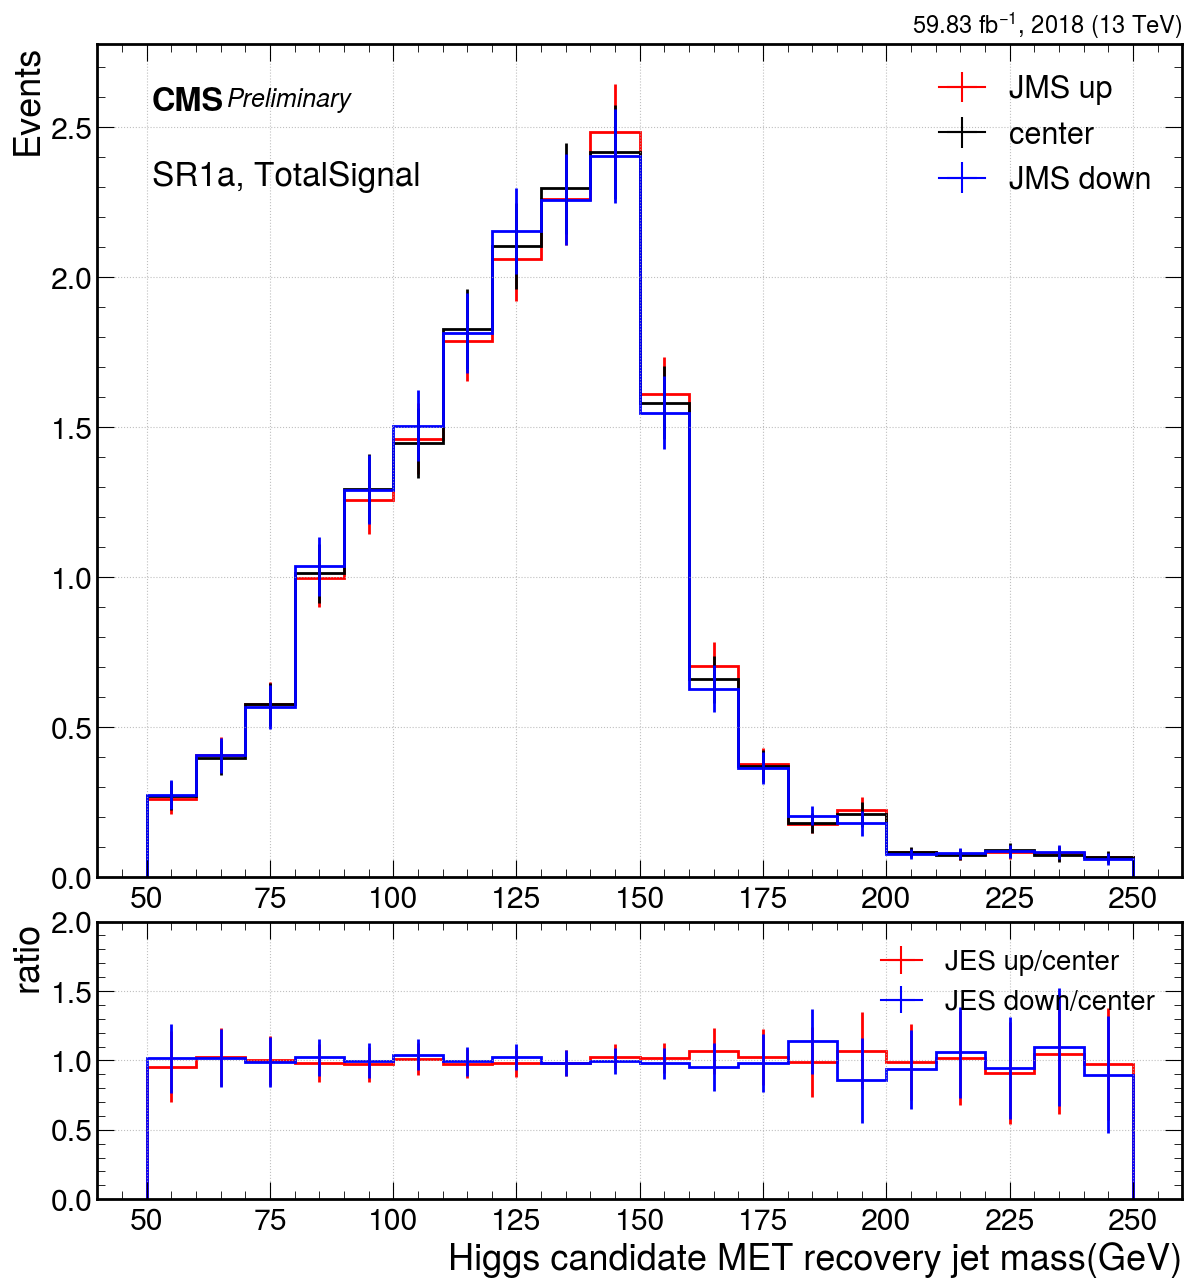

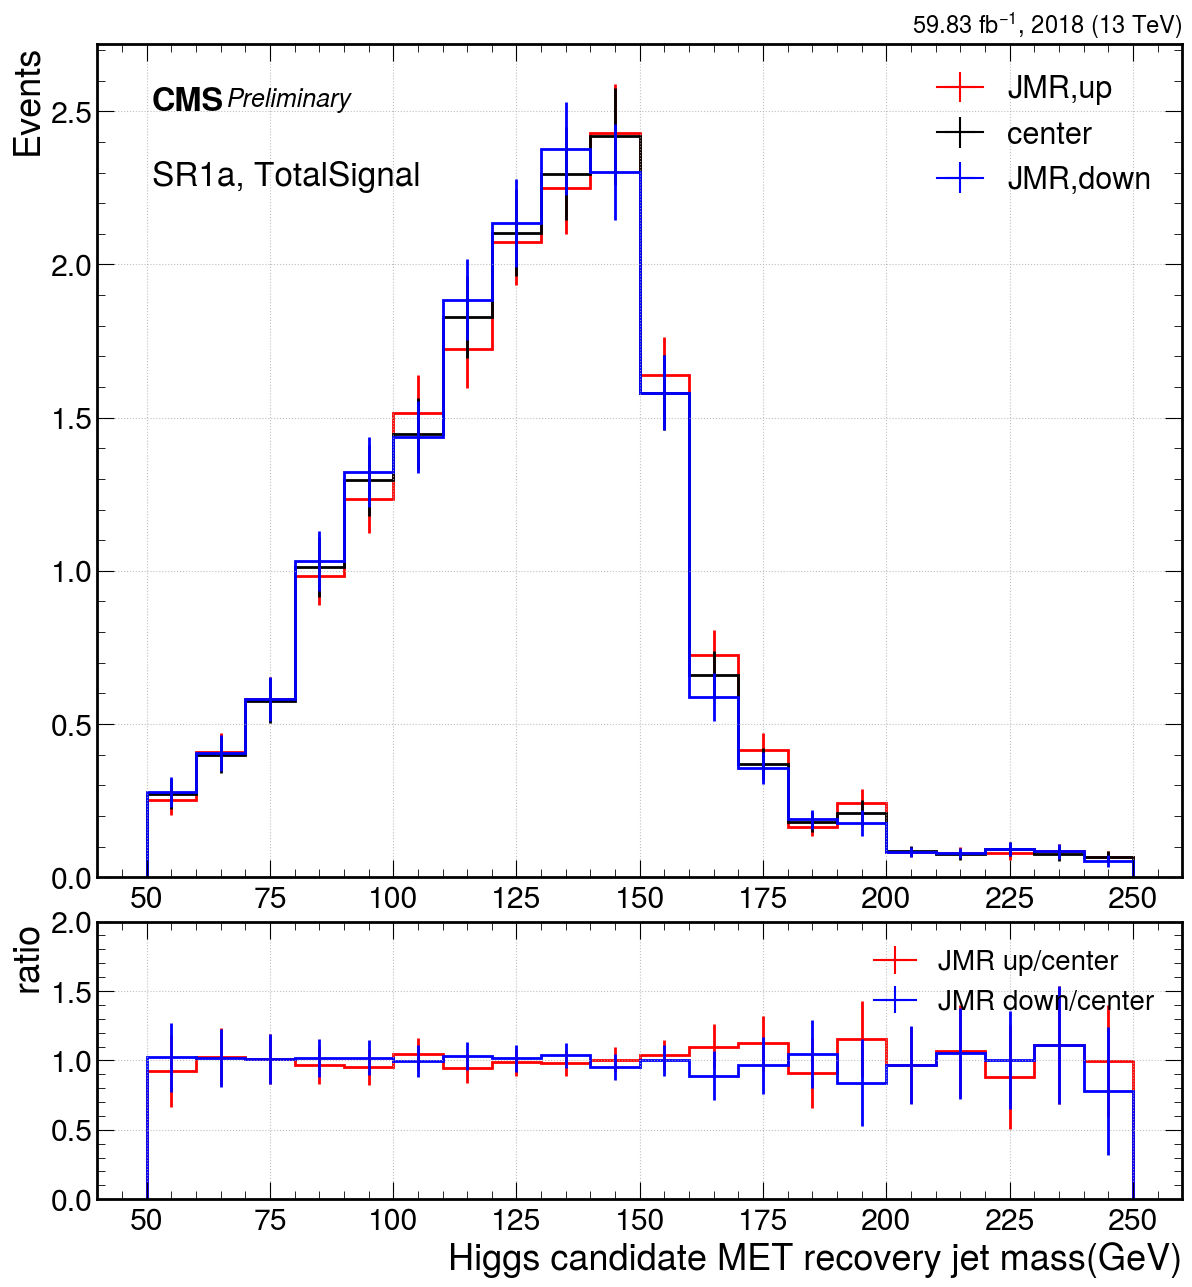

In [13]:
plot_JMS_JMR_variation(files, files_str = "TotalSignal",region = "SR1a")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",region = "SR1b")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",region = "SR2a")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",region = "SR2b")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",region = "PS")

plot_JMS_JMR_variation(files, files_str = "TotalSignal",plot_JMS = False, region = "SR1a")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",plot_JMS = False, region = "SR1b")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",plot_JMS = False, region = "SR2a")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",plot_JMS = False, region = "SR2b")
# plot_JMS_JMR_variation(files, files_str = "TotalSignal",plot_JMS = False, region = "PS")

# plot_JMS_JMR_variation(files, files_str = "Top",region = "SR1a")
# plot_JMS_JMR_variation(files, files_str = "Top",region = "SR1b")
# plot_JMS_JMR_variation(files, files_str = "Top",region = "SR2a")
# plot_JMS_JMR_variation(files, files_str = "Top",region = "SR2b")
# plot_JMS_JMR_variation(files, files_str = "Top",region = "PS")

# plot_JMS_JMR_variation(files, files_str = "Top",plot_JMS = False, region = "SR1a")
# plot_JMS_JMR_variation(files, files_str = "Top",plot_JMS = False, region = "SR1b")
# plot_JMS_JMR_variation(files, files_str = "Top",plot_JMS = False, region = "SR2a")
# plot_JMS_JMR_variation(files, files_str = "Top",plot_JMS = False, region = "SR2b")
# plot_JMS_JMR_variation(files, files_str = "Top",plot_JMS = False, region = "PS")

### MET UE up/down

In [ ]:
def plot_MET_UE_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_UE = True,year = "2018",files_str = ''):
    files = files[files_str]
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_UE:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco_UE_up"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="Adding MET unclustered energy up variation", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco_UE_down"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="Removing MET unclustered energy up variation", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="down var./center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=18)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", " + files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/MET_{year}_{region}{files_str}.pdf", bbox_inches='tight')    

In [ ]:
plot_MET_UE_variation(files , files_str = "TotalSignal",region = "SR1a")
plot_MET_UE_variation(files , files_str = "TotalSignal",region = "SR1b")
plot_MET_UE_variation(files , files_str = "TotalSignal",region = "SR2a")
plot_MET_UE_variation(files , files_str = "TotalSignal",region = "SR2b")
plot_MET_UE_variation(files , files_str = "TotalSignal",region = "PS")

plot_MET_UE_variation(files, files_str = "Top",region = "SR1a")
plot_MET_UE_variation(files, files_str = "Top",region = "SR1b")
plot_MET_UE_variation(files, files_str = "Top",region = "SR2a")
plot_MET_UE_variation(files, files_str = "Top",region = "SR2b")
plot_MET_UE_variation(files, files_str = "Top",region = "PS")

plot_MET_UE_variation(files, files_str = "WJets",region = "SR1a")
plot_MET_UE_variation(files, files_str = "WJets",region = "SR1b")
plot_MET_UE_variation(files, files_str = "WJets",region = "SR2a")
plot_MET_UE_variation(files, files_str = "WJets",region = "SR2b")
plot_MET_UE_variation(files, files_str = "WJets",region = "PS")

### split JES

In [10]:
def plot_JES_split_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_JES = True,year = "2018",files_str = "", source = "Absolute"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    files = files[files_str]
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_JES:
        legend_source = source
        if "year" in source:
            legend_source = source.replace("year",year)
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jes" + source + "Up_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JES, " +legend_source+ " up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jes" + source + "Down_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JES," +legend_source+ " down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JES," + legend_source + " up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JES," + legend_source + " down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    


        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region+ ", "+ files_str,fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JES_{year}_{region}{legend_source}{files_str}.pdf", bbox_inches='tight')    


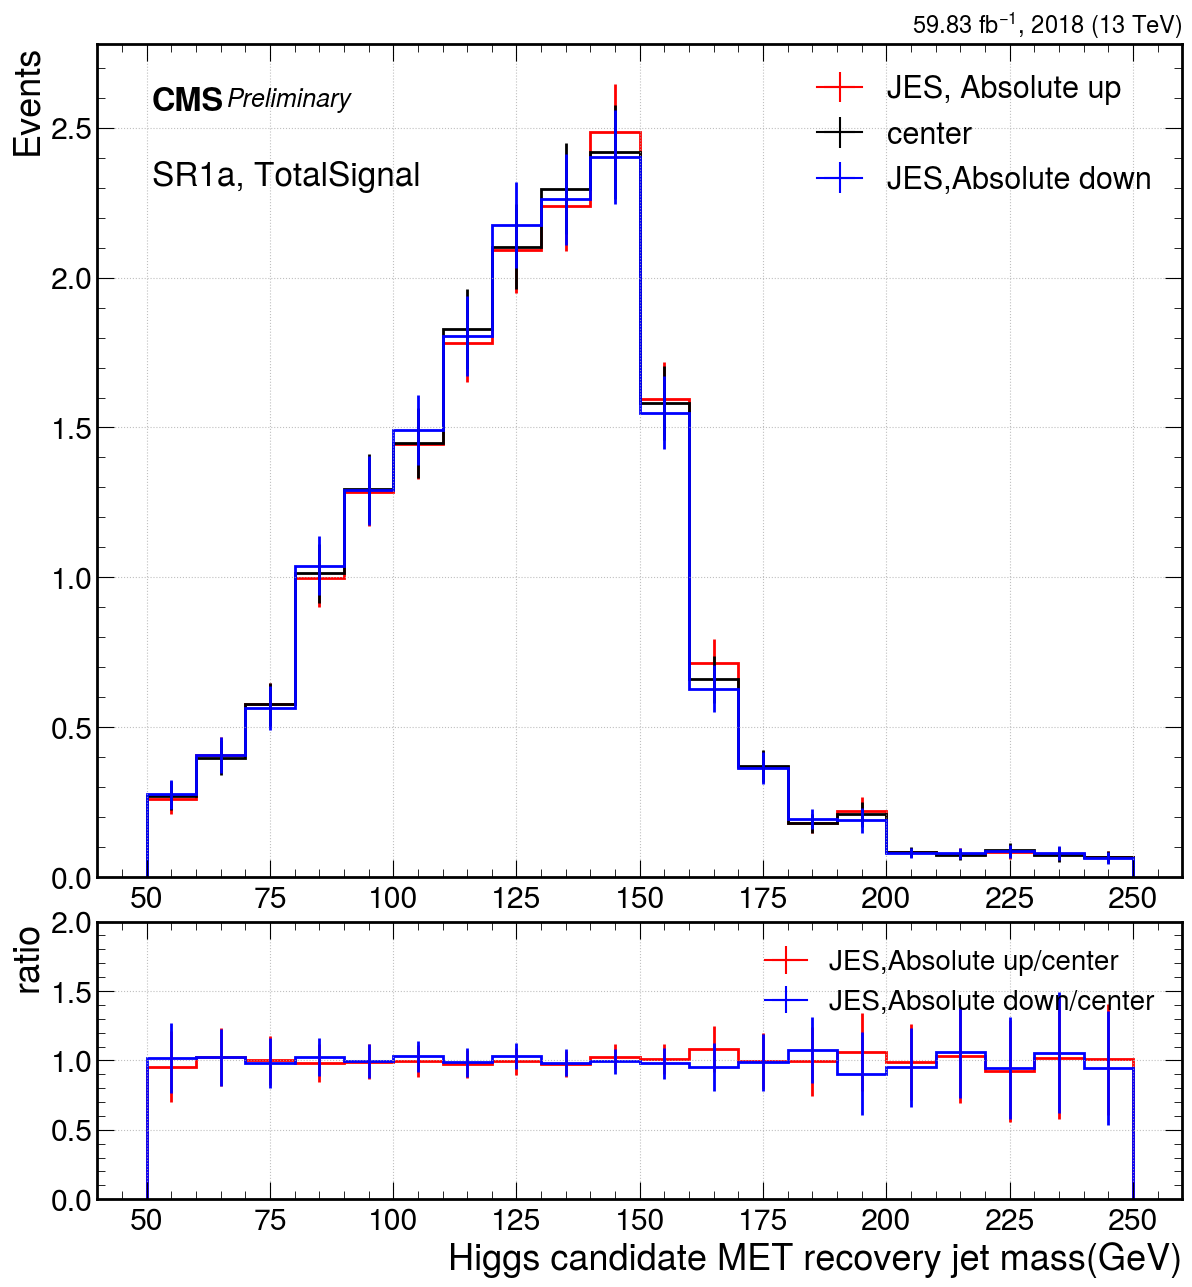

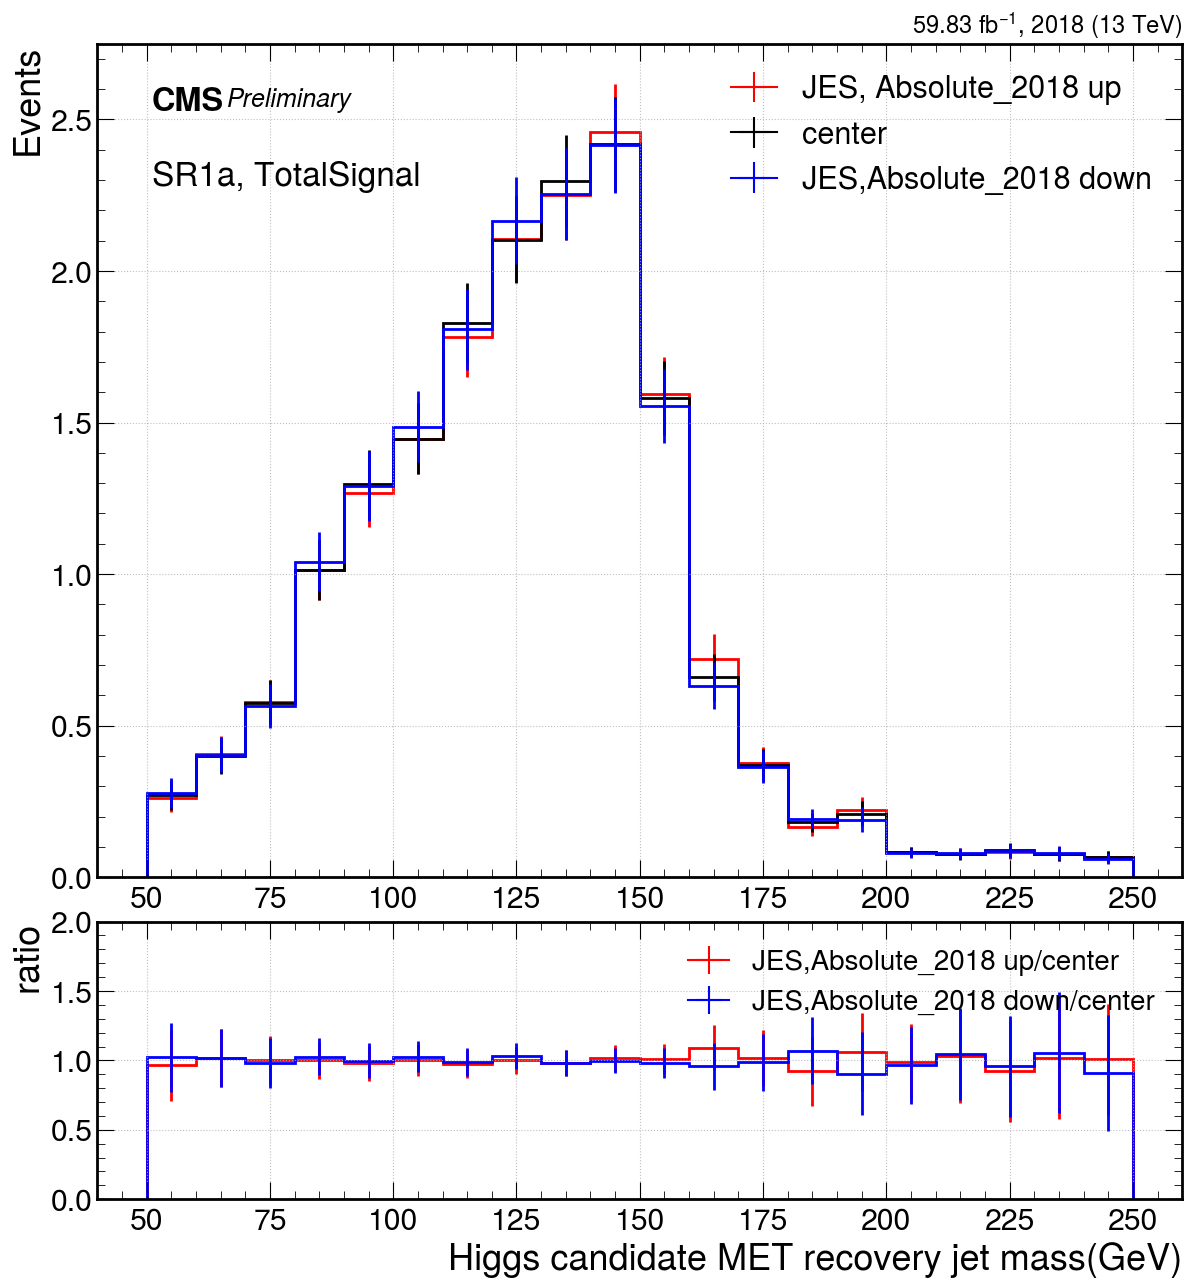

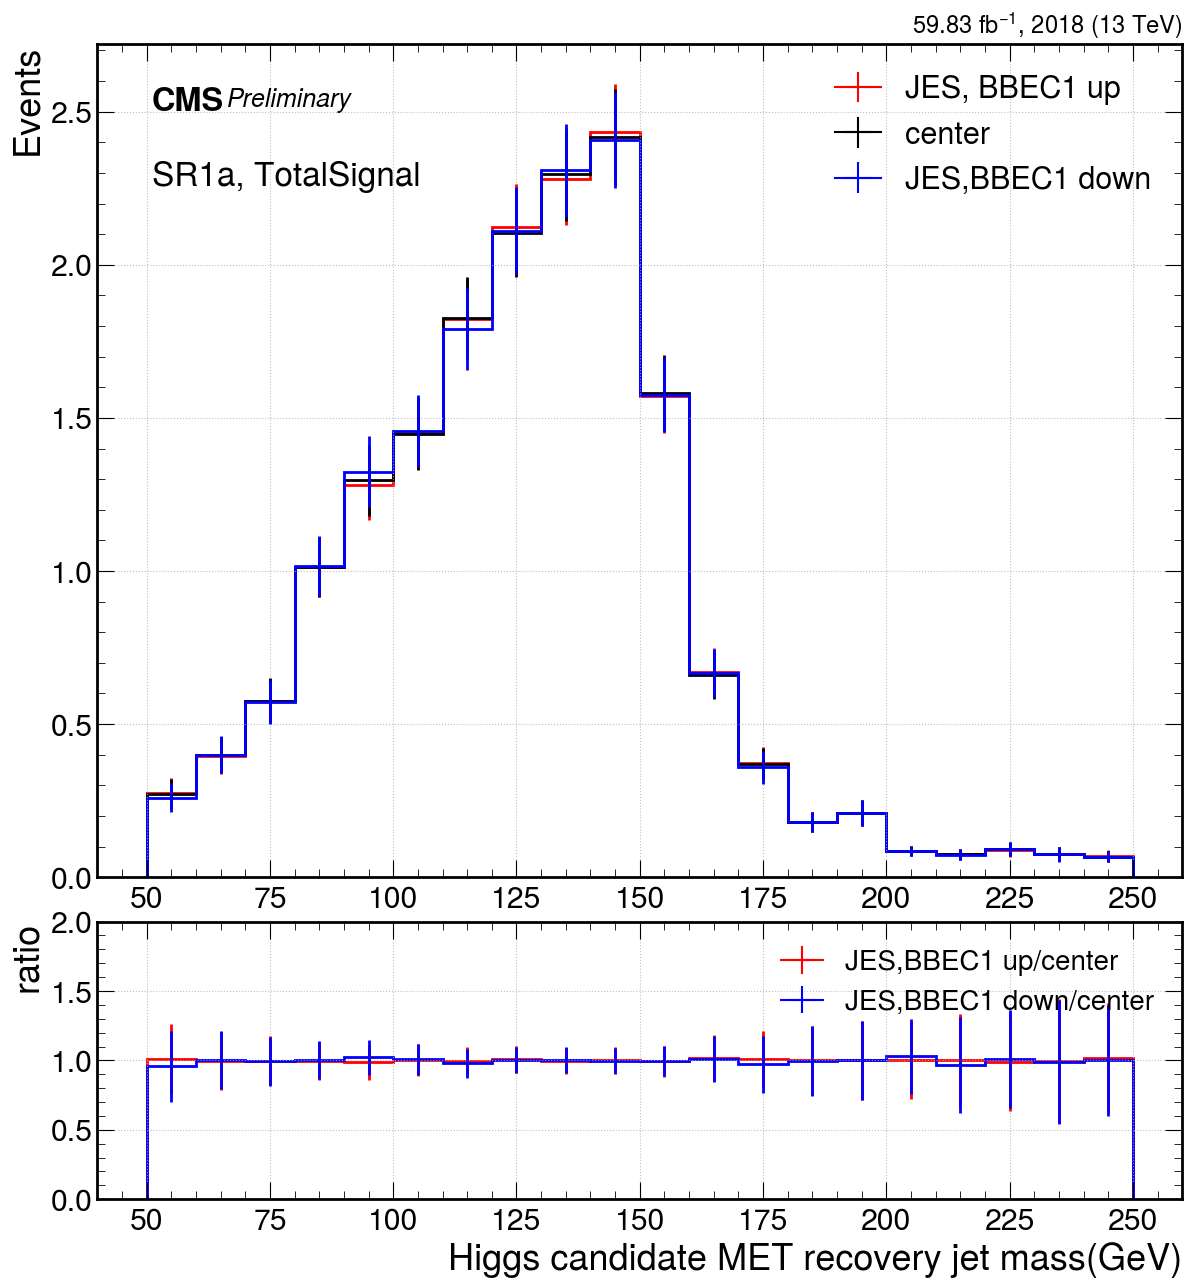

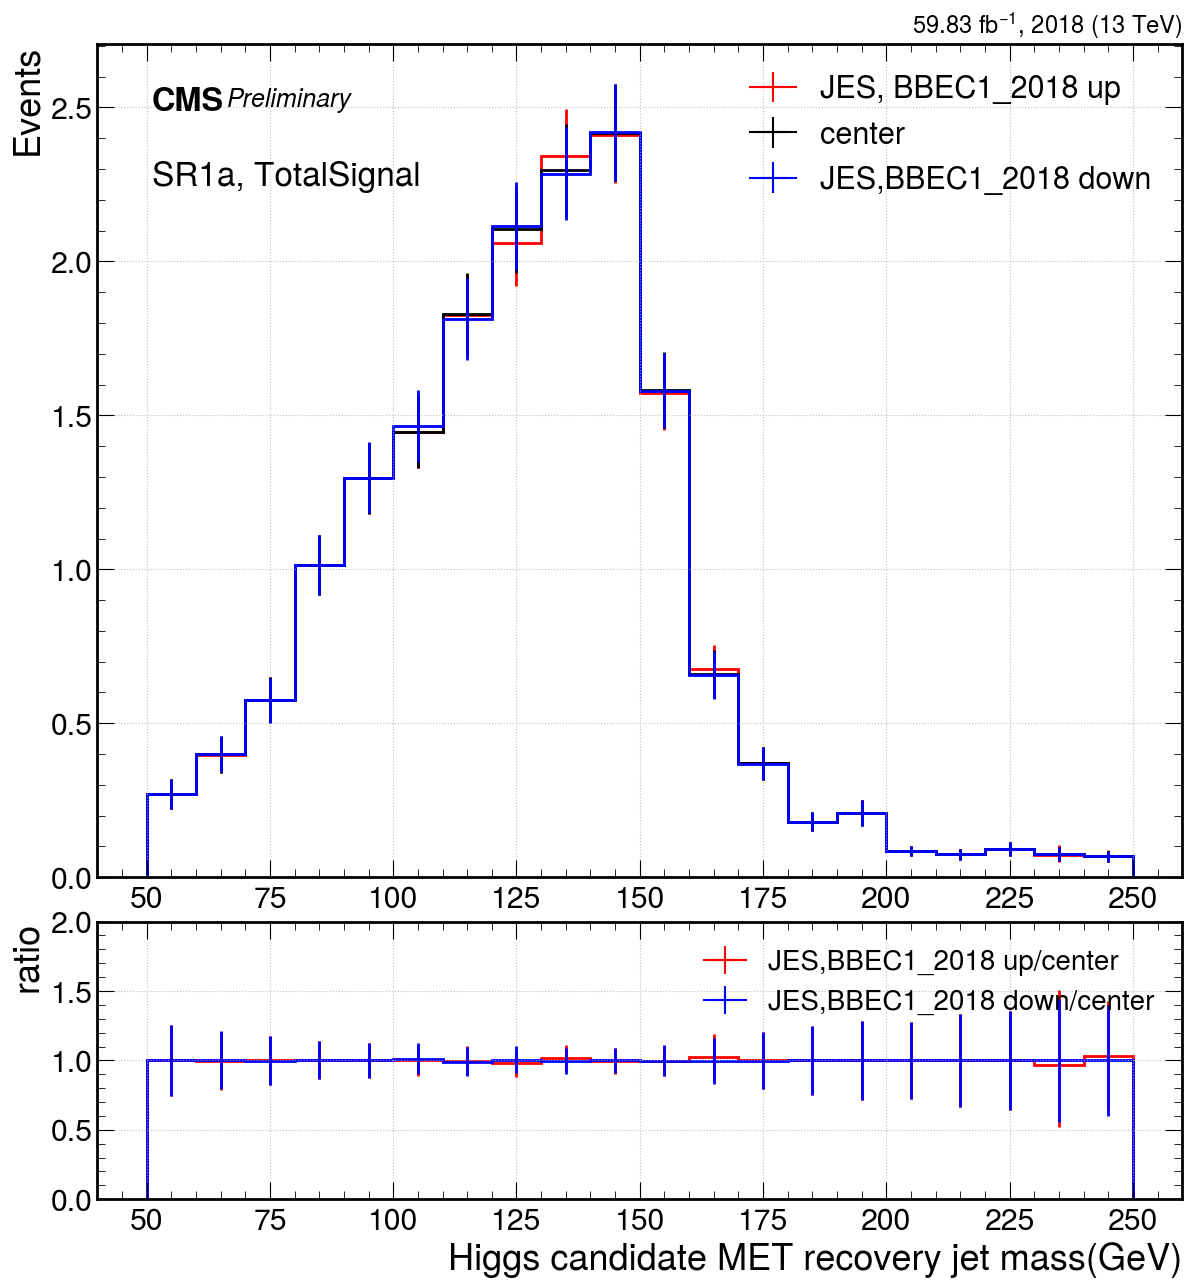

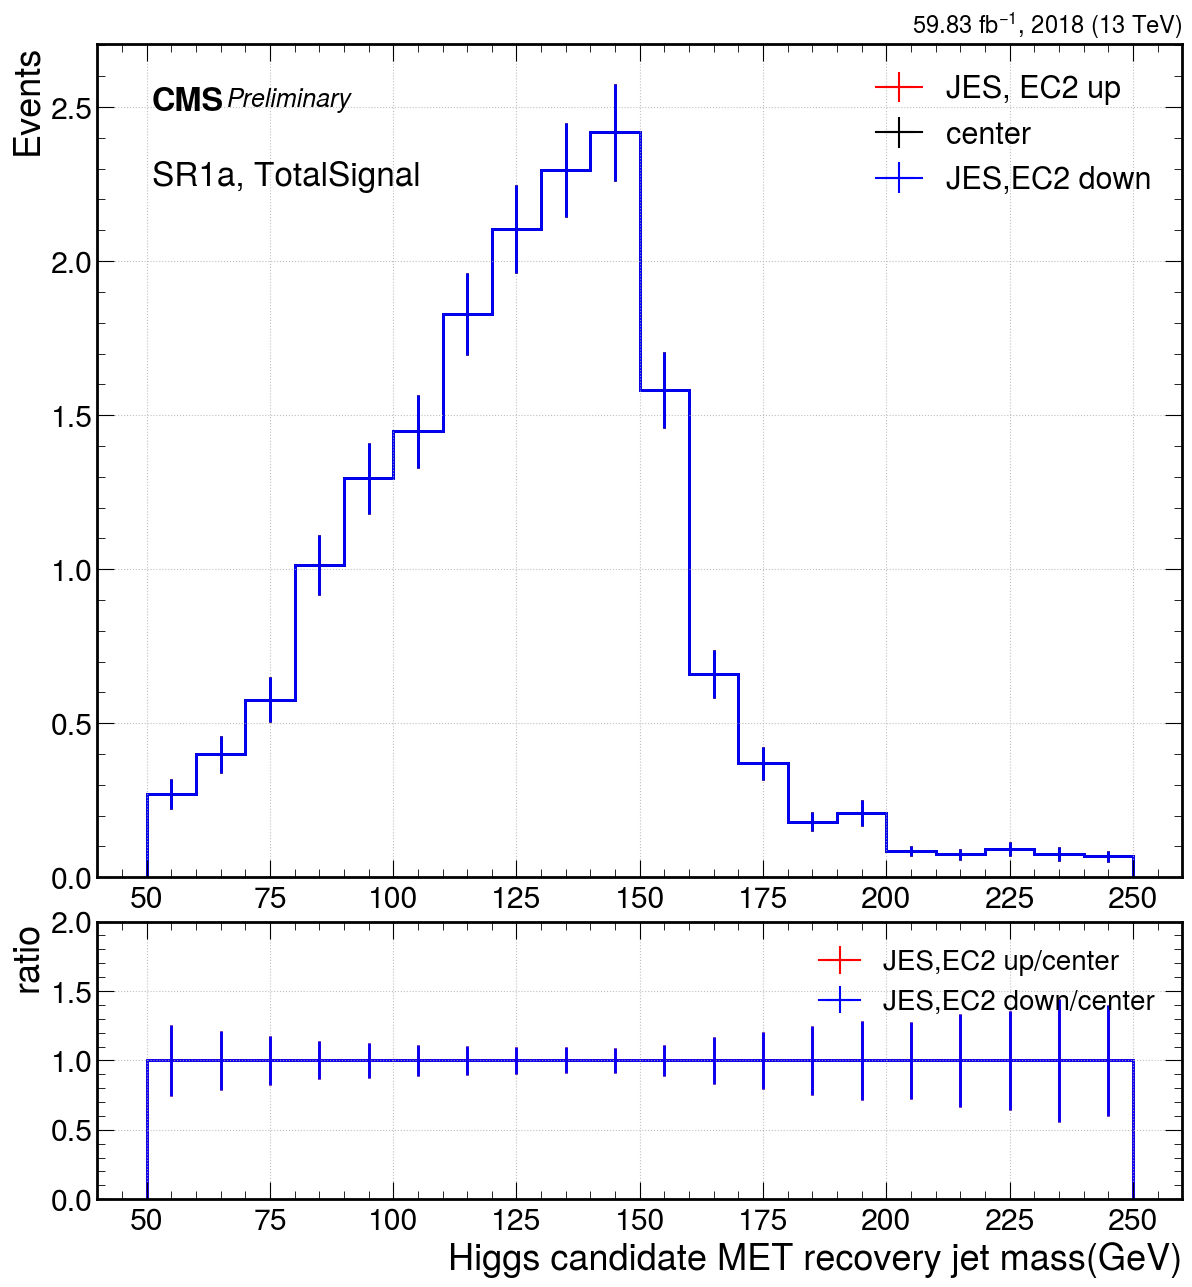

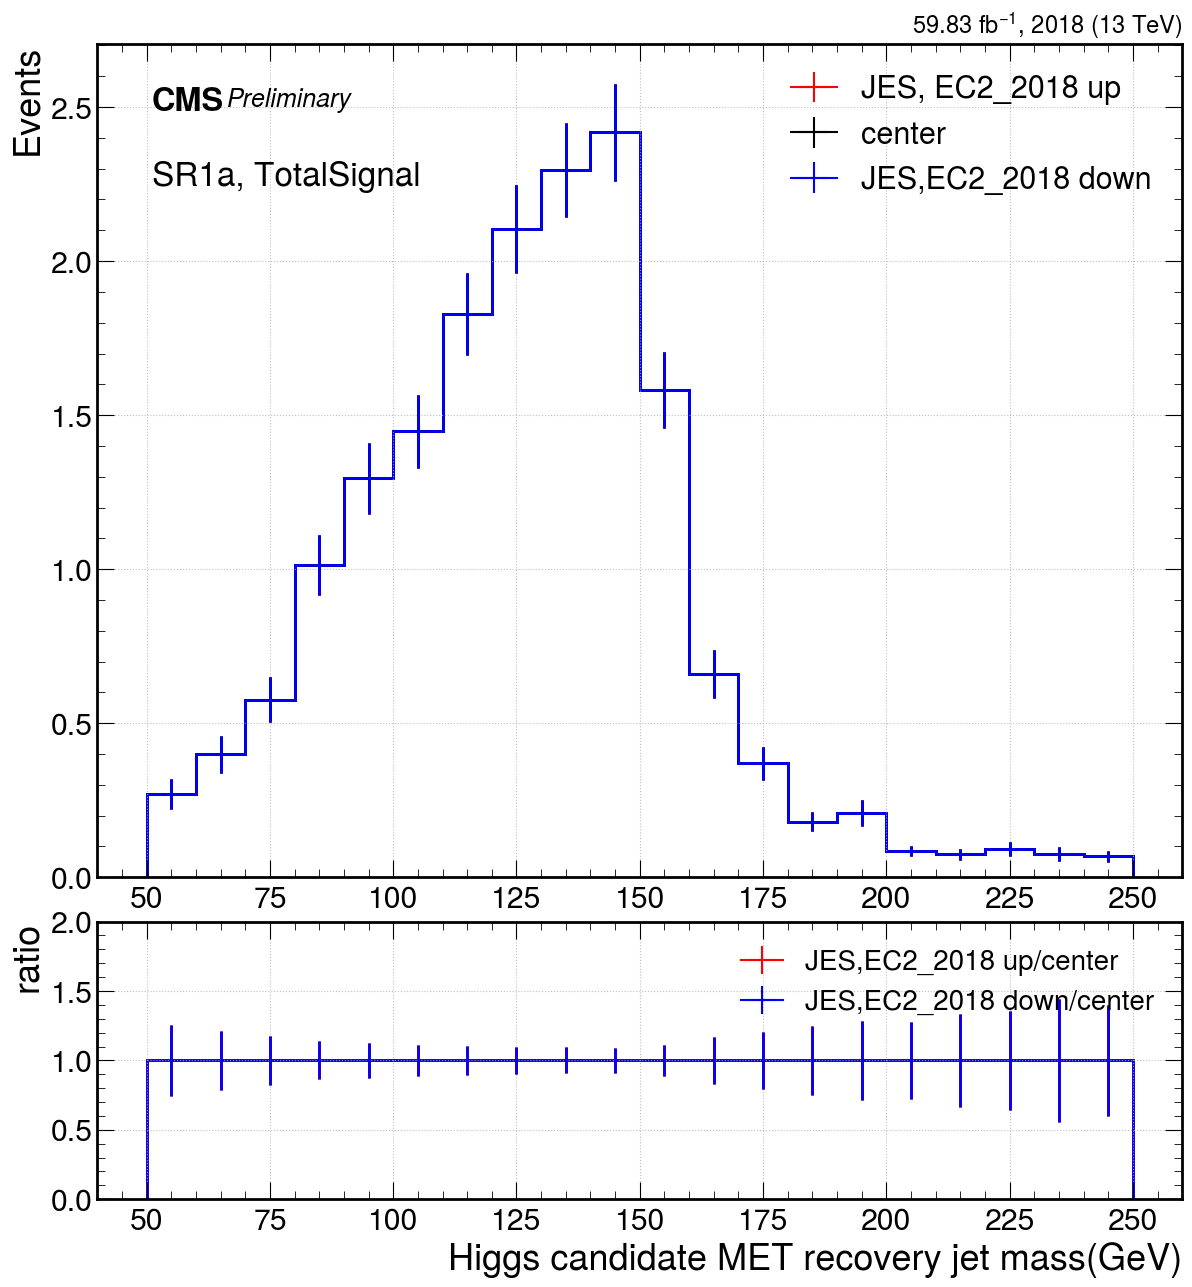

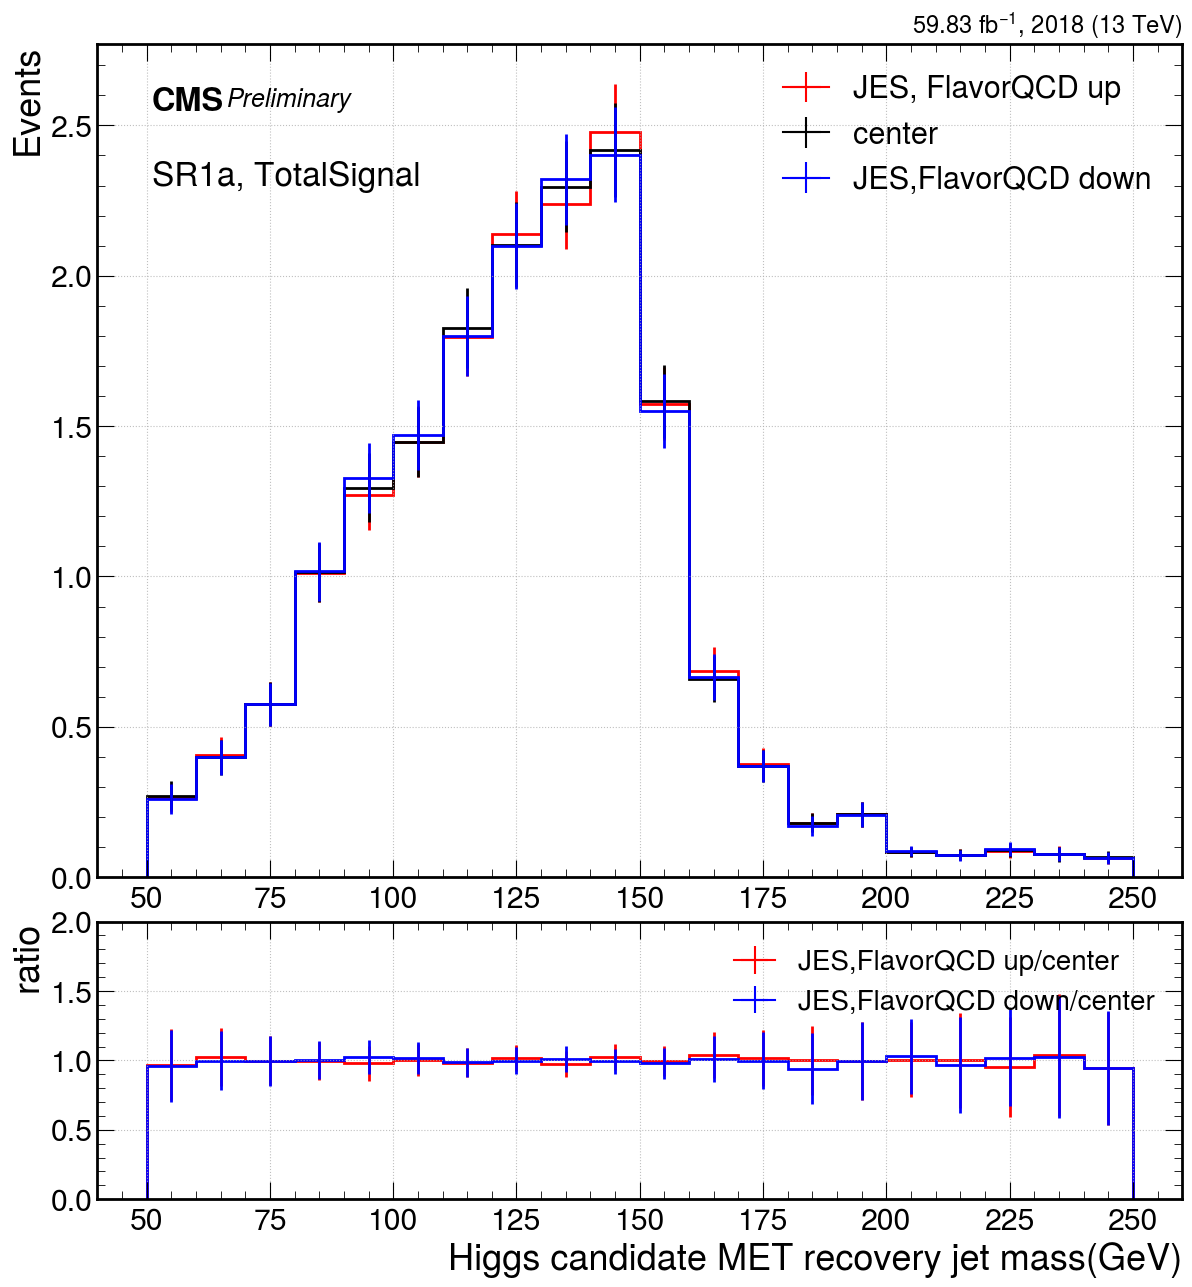

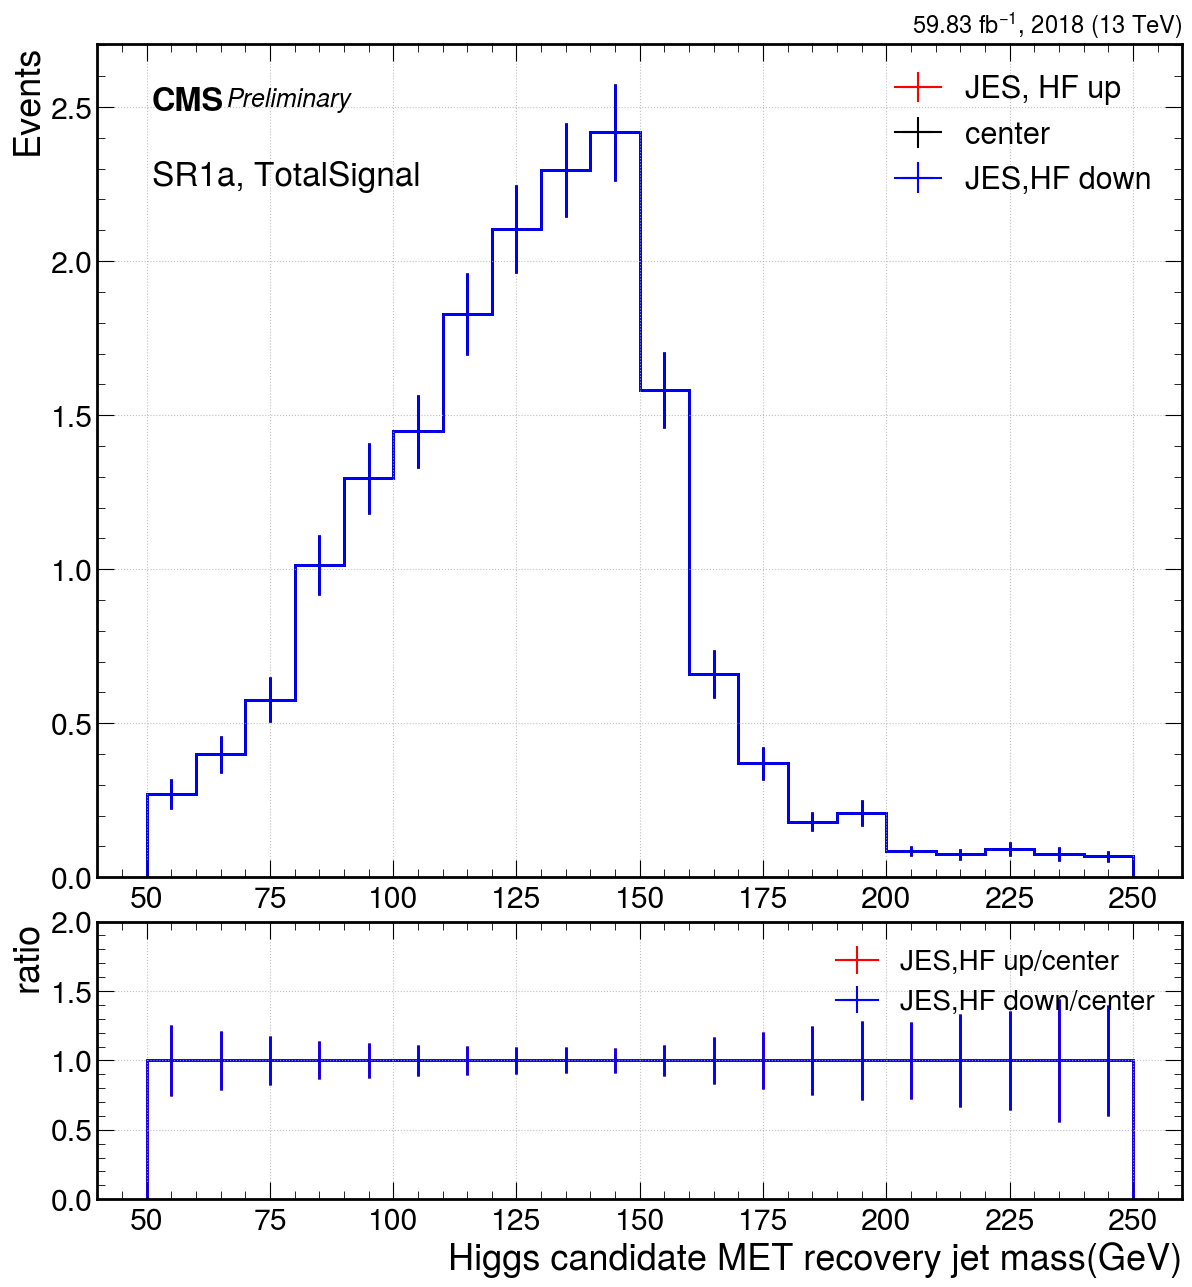

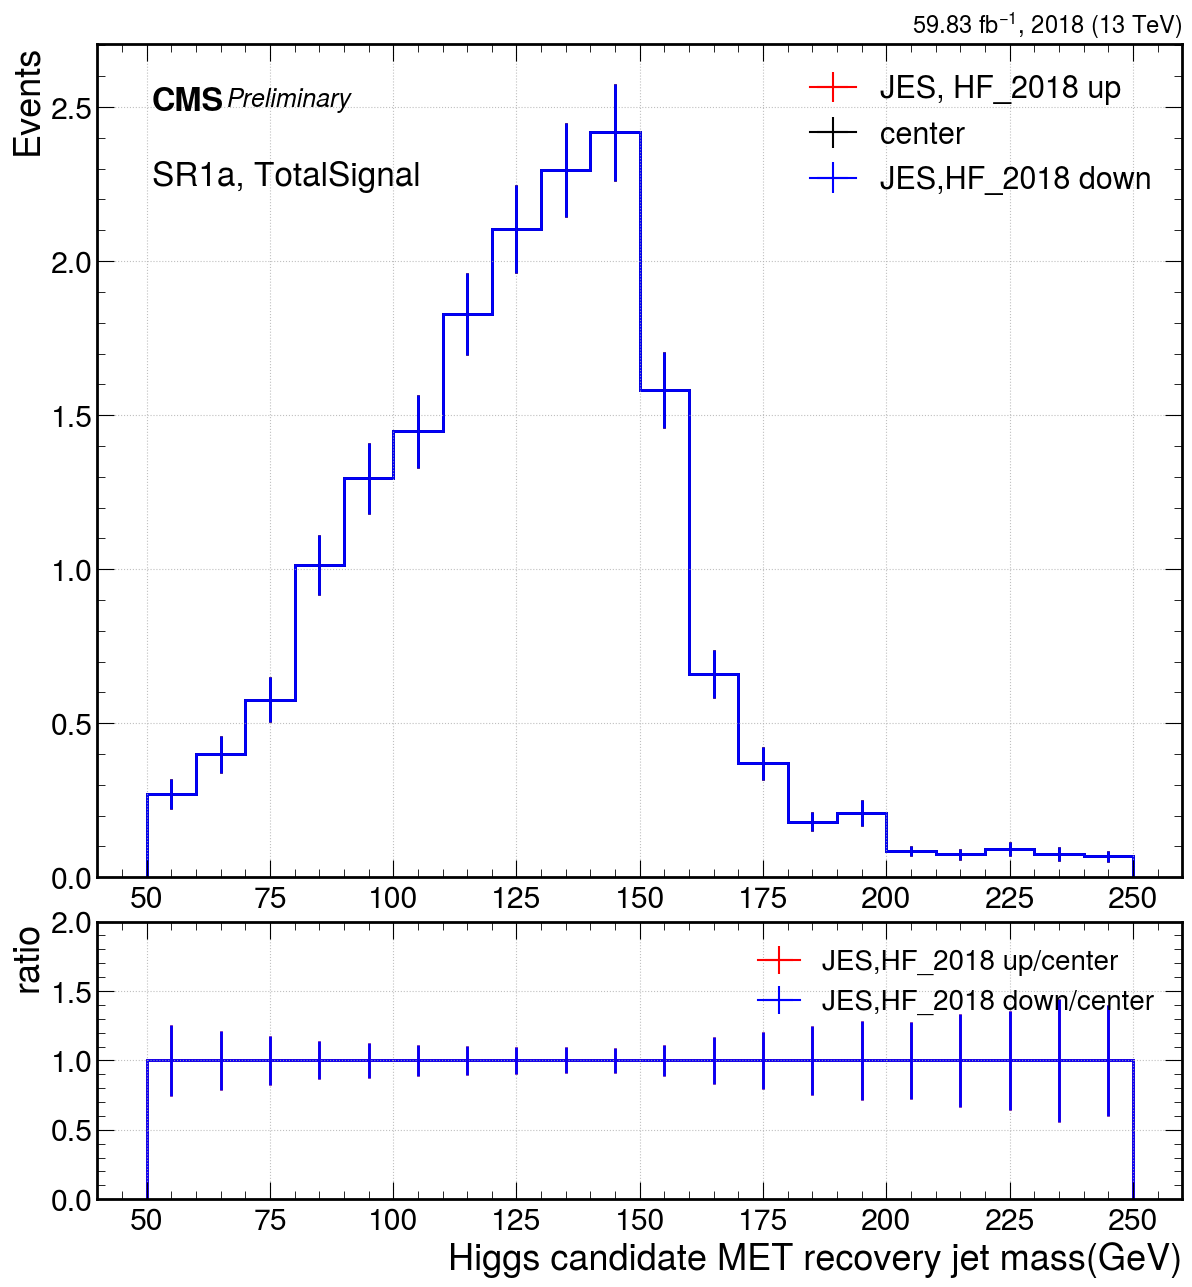

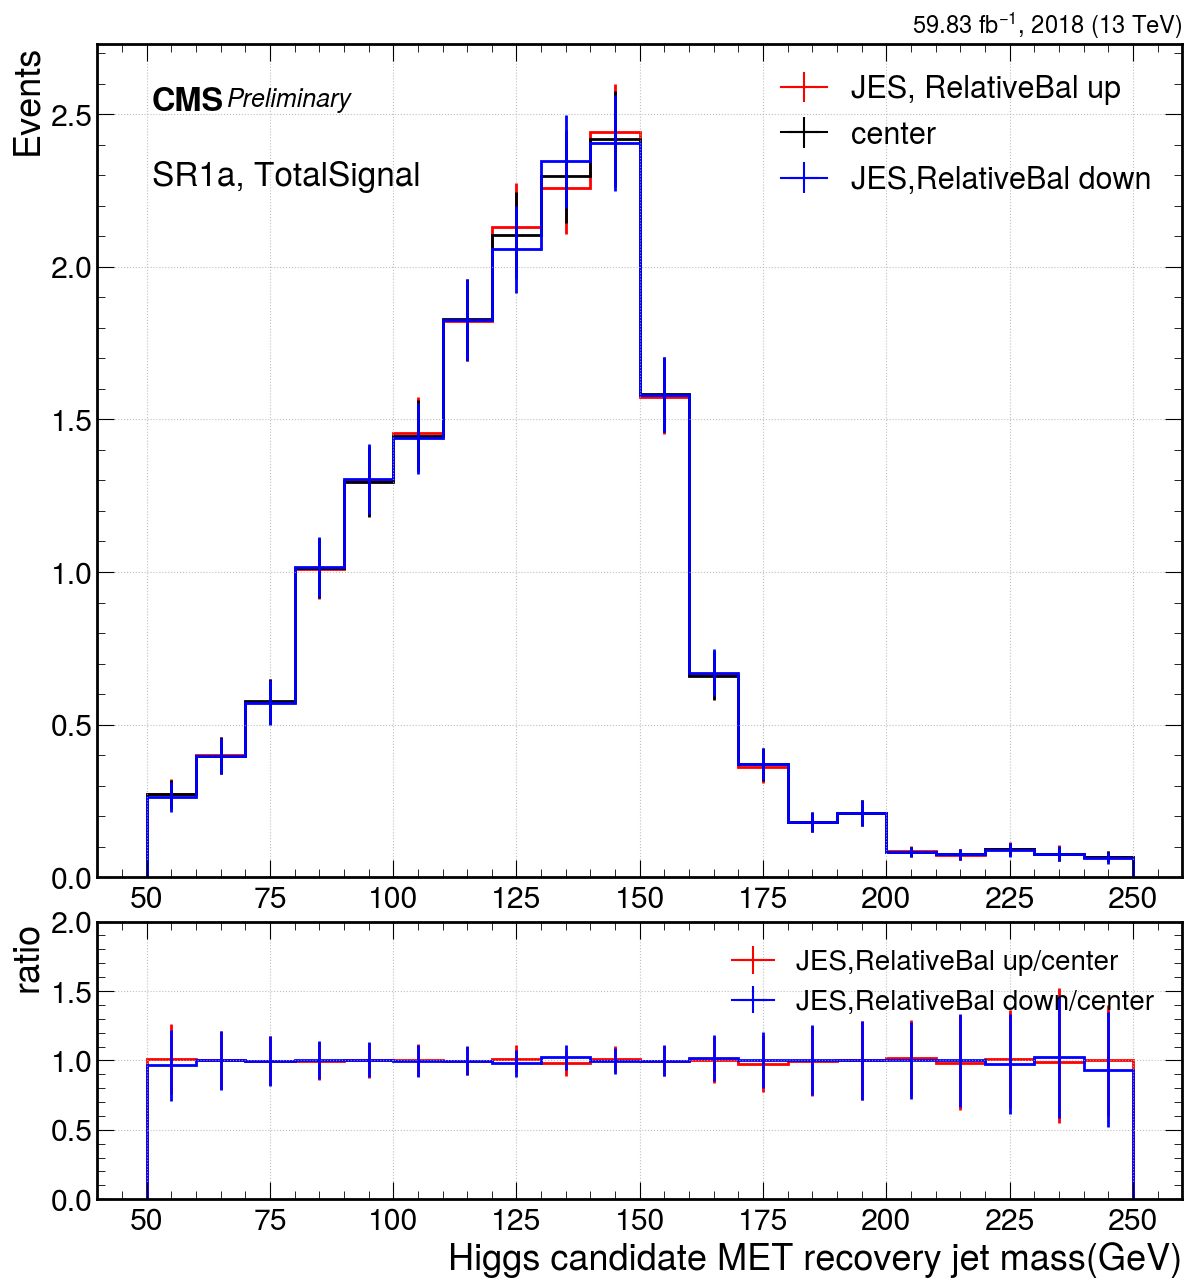

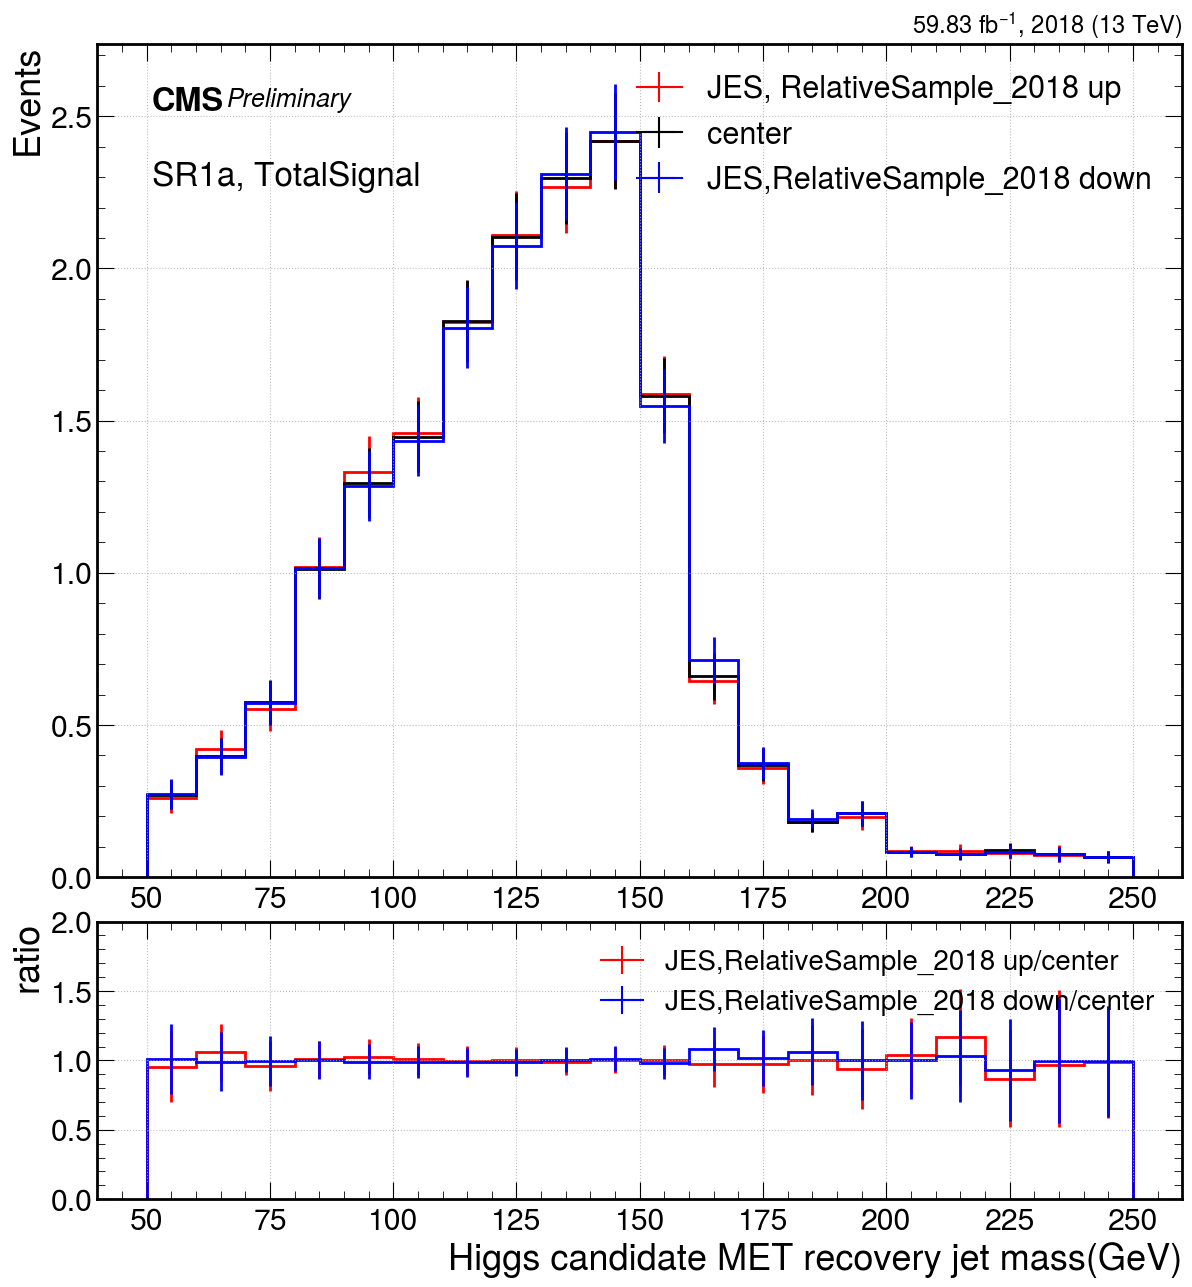

In [11]:
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "Absolute")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "Absolute_year")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "BBEC1")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "BBEC1_year")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "EC2")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "EC2_year")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "FlavorQCD")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "HF")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "HF_year")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "RelativeBal")
plot_JES_split_variation(files, files_str = "TotalSignal",region = "SR1a",source = "RelativeSample_year")